<a href="https://colab.research.google.com/github/Viroslav/DLS/blob/main/CNN/%5Bhomework%5Ddense_and_convolutional_nn_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [237]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [238]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

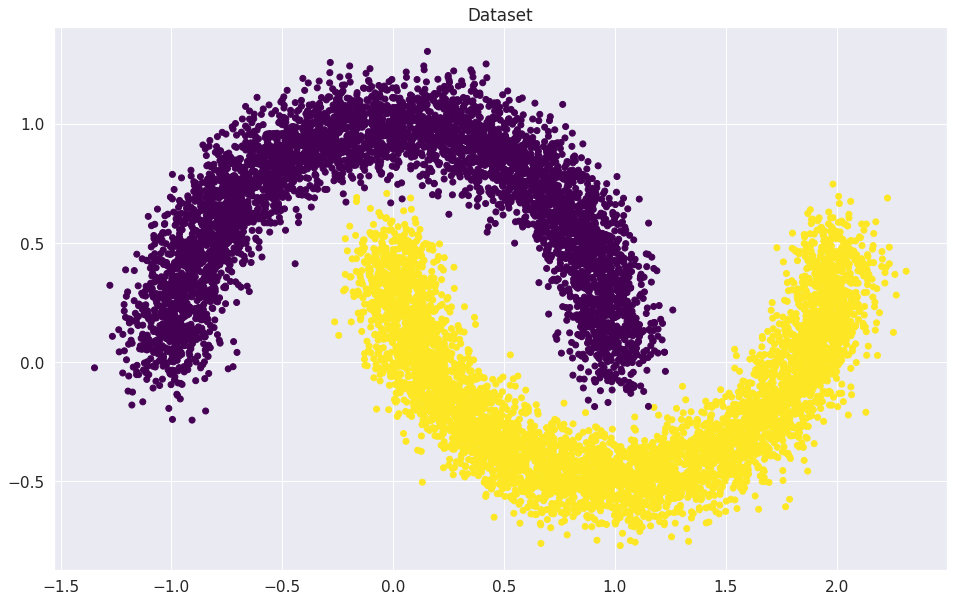

In [239]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [240]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [241]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [242]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоиды. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [243]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weights = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.zeros(out_features))

    def forward(self, x):
        x = x @ self.weights
        if self.bias:
            x += self.bias_term
        return x

In [244]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [245]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-0.7229],
         [-0.0014]], requires_grad=True), Parameter containing:
 tensor([0.], requires_grad=True)]

**У получившейся модели 3 обучаемых параметра W размерности 2x1 и bias 1x1**

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [246]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression.forward(X_batch)[:, 0]                        
        loss =  loss_function(outp, y_batch)                                   
        loss.backward()                         
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  torch.sigmoid(outp)                                    
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3125
Iteration: 100
Batch accuracy: 0.84375
Iteration: 200
Batch accuracy: 0.828125
Iteration: 300
Batch accuracy: 0.90625
Iteration: 400
Batch accuracy: 0.890625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.875
Iteration: 700
Batch accuracy: 0.828125

Iteration: 755.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 755

### Визуализируем результаты

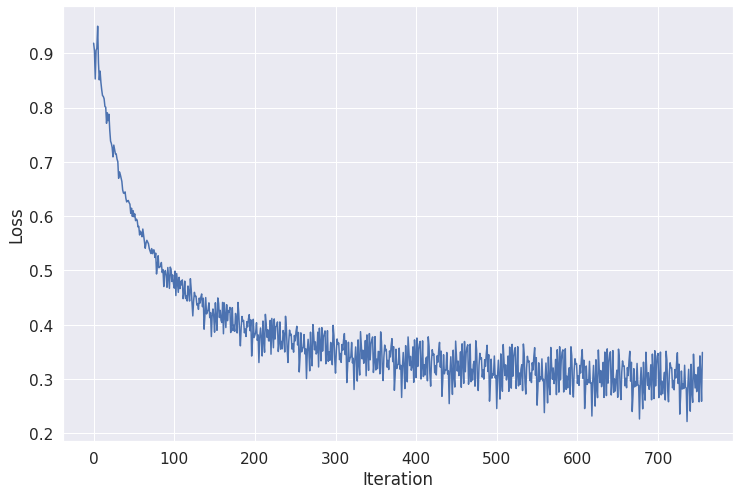

In [247]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

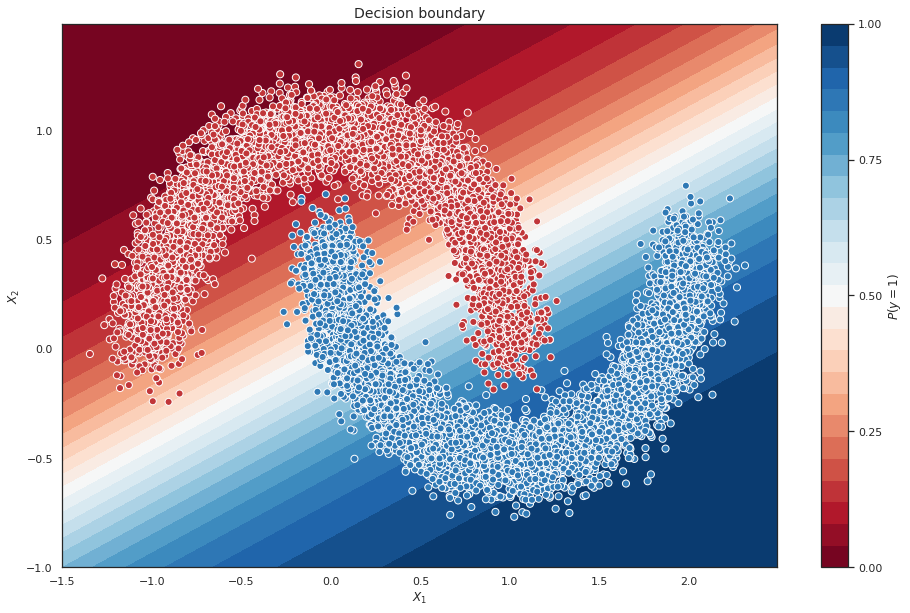

In [248]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [249]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = (torch.sigmoid(model.forward(x_batch)[:, 0]) > 0.5).type(torch.long)   # X*w + b --> ответ, от него сигмоиду и если > 0.5, то 1, иначе 0
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [250]:
from sklearn.metrics import accuracy_score


accuracy_score(y_val_t, predict(val_dataloader, linear_regression))

0.8672

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8672

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [76]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [77]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [103]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
)

In [104]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [145]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval() 
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (y_batch == preds).sum()
            all =  (y_batch == y_batch).sum()
            epoch_correct += correct.item()
            epoch_all += all
            
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.9898166656494141
Loader: valid. Accuracy: 0.97489994764328
Epoch: 2
Loader: train. Accuracy: 0.991100013256073
Loader: valid. Accuracy: 0.9747999906539917
Epoch: 3
Loader: train. Accuracy: 0.9916166663169861
Loader: valid. Accuracy: 0.9754999876022339
Epoch: 4
Loader: train. Accuracy: 0.9926833510398865
Loader: valid. Accuracy: 0.9716999530792236
Epoch: 5
Loader: train. Accuracy: 0.992566704750061
Loader: valid. Accuracy: 0.9772999882698059
Epoch: 6
Loader: train. Accuracy: 0.9930333495140076
Loader: valid. Accuracy: 0.9759999513626099
Epoch: 7
Loader: train. Accuracy: 0.9927499890327454
Loader: valid. Accuracy: 0.9759999513626099
Epoch: 8
Loader: train. Accuracy: 0.994450032711029
Loader: valid. Accuracy: 0.9729999899864197
Epoch: 9
Loader: train. Accuracy: 0.9944999814033508
Loader: valid. Accuracy: 0.9750999808311462
Epoch: 10
Loader: train. Accuracy: 0.9939000010490417
Loader: valid. Accuracy: 0.9781999588012695


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [146]:
elu_accuracy = accuracy["valid"]

In [147]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
  model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 128),
  activation(),
  nn.Linear(128, 128),
  activation(),
  nn.Linear(128, 10))
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters())
  accuracy = {"train": [], "valid": []} 
  loaders = {"train": train_dataloader, "valid": valid_dataloader}
  for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval() 
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (y_batch == preds).sum()
            all =  (y_batch == y_batch).sum()
            epoch_correct += correct.item()
            epoch_all += all
            
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
  return accuracy["valid"]

In [148]:
relu_accuracy = test_activation_function(nn.ReLU)

Epoch: 1
Loader: train. Accuracy: 0.8705500364303589
Loader: valid. Accuracy: 0.9257999658584595
Epoch: 2
Loader: train. Accuracy: 0.93545001745224
Loader: valid. Accuracy: 0.9461999535560608
Epoch: 3
Loader: train. Accuracy: 0.95291668176651
Loader: valid. Accuracy: 0.9562000036239624
Epoch: 4
Loader: train. Accuracy: 0.9627500176429749
Loader: valid. Accuracy: 0.9577999711036682
Epoch: 5
Loader: train. Accuracy: 0.9695000052452087
Loader: valid. Accuracy: 0.960099995136261
Epoch: 6
Loader: train. Accuracy: 0.9737833738327026
Loader: valid. Accuracy: 0.9633999466896057
Epoch: 7
Loader: train. Accuracy: 0.977400004863739
Loader: valid. Accuracy: 0.9643999934196472
Epoch: 8
Loader: train. Accuracy: 0.9798666834831238
Loader: valid. Accuracy: 0.9648000001907349
Epoch: 9
Loader: train. Accuracy: 0.9810667037963867
Loader: valid. Accuracy: 0.9662999510765076
Epoch: 10
Loader: train. Accuracy: 0.9826499819755554
Loader: valid. Accuracy: 0.9643999934196472


In [149]:
plain_accuracy = test_activation_function(Identical)

Epoch: 1
Loader: train. Accuracy: 0.8632833361625671
Loader: valid. Accuracy: 0.8841999769210815
Epoch: 2
Loader: train. Accuracy: 0.8951833248138428
Loader: valid. Accuracy: 0.9003999829292297
Epoch: 3
Loader: train. Accuracy: 0.9002166986465454
Loader: valid. Accuracy: 0.9001999497413635
Epoch: 4
Loader: train. Accuracy: 0.9028833508491516
Loader: valid. Accuracy: 0.9003999829292297
Epoch: 5
Loader: train. Accuracy: 0.9045667052268982
Loader: valid. Accuracy: 0.9010999798774719
Epoch: 6
Loader: train. Accuracy: 0.9056833386421204
Loader: valid. Accuracy: 0.9017999768257141
Epoch: 7
Loader: train. Accuracy: 0.9069499969482422
Loader: valid. Accuracy: 0.9016000032424927
Epoch: 8
Loader: train. Accuracy: 0.9081500172615051
Loader: valid. Accuracy: 0.902899980545044
Epoch: 9
Loader: train. Accuracy: 0.9096166491508484
Loader: valid. Accuracy: 0.9035999774932861
Epoch: 10
Loader: train. Accuracy: 0.910099983215332
Loader: valid. Accuracy: 0.9053999781608582


In [150]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8715500235557556
Loader: valid. Accuracy: 0.9230999946594238
Epoch: 2
Loader: train. Accuracy: 0.9343500137329102
Loader: valid. Accuracy: 0.9437999725341797
Epoch: 3
Loader: train. Accuracy: 0.9526166915893555
Loader: valid. Accuracy: 0.9519999623298645
Epoch: 4
Loader: train. Accuracy: 0.9629833698272705
Loader: valid. Accuracy: 0.9627999663352966
Epoch: 5
Loader: train. Accuracy: 0.9696000218391418
Loader: valid. Accuracy: 0.9666999578475952
Epoch: 6
Loader: train. Accuracy: 0.9745000004768372
Loader: valid. Accuracy: 0.9661999940872192
Epoch: 7
Loader: train. Accuracy: 0.9774500131607056
Loader: valid. Accuracy: 0.9695999622344971
Epoch: 8
Loader: train. Accuracy: 0.9797333478927612
Loader: valid. Accuracy: 0.968999981880188
Epoch: 9
Loader: train. Accuracy: 0.9822666645050049
Loader: valid. Accuracy: 0.9704999923706055
Epoch: 10
Loader: train. Accuracy: 0.9848166704177856
Loader: valid. Accuracy: 0.971299946308136


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

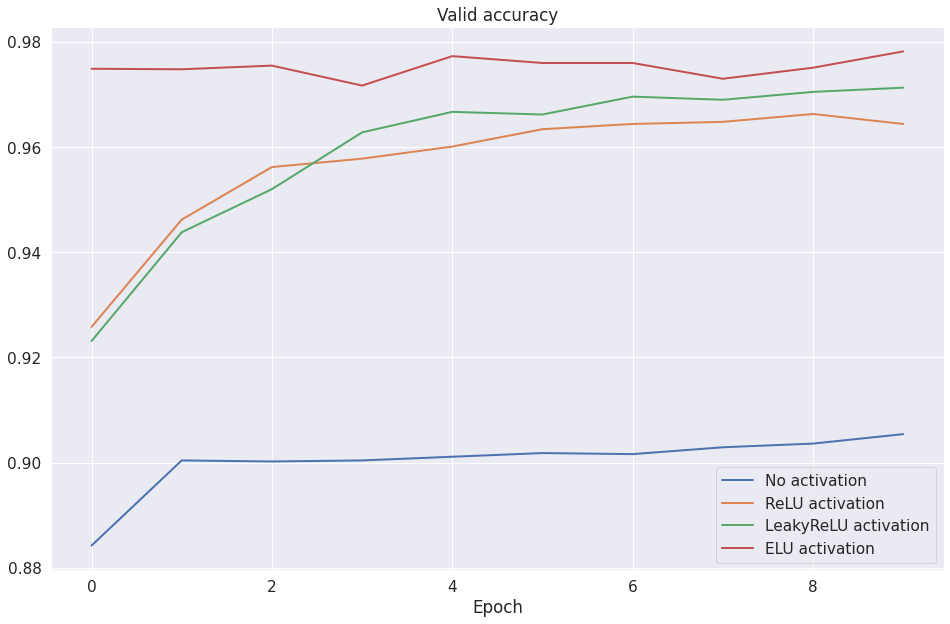

In [151]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

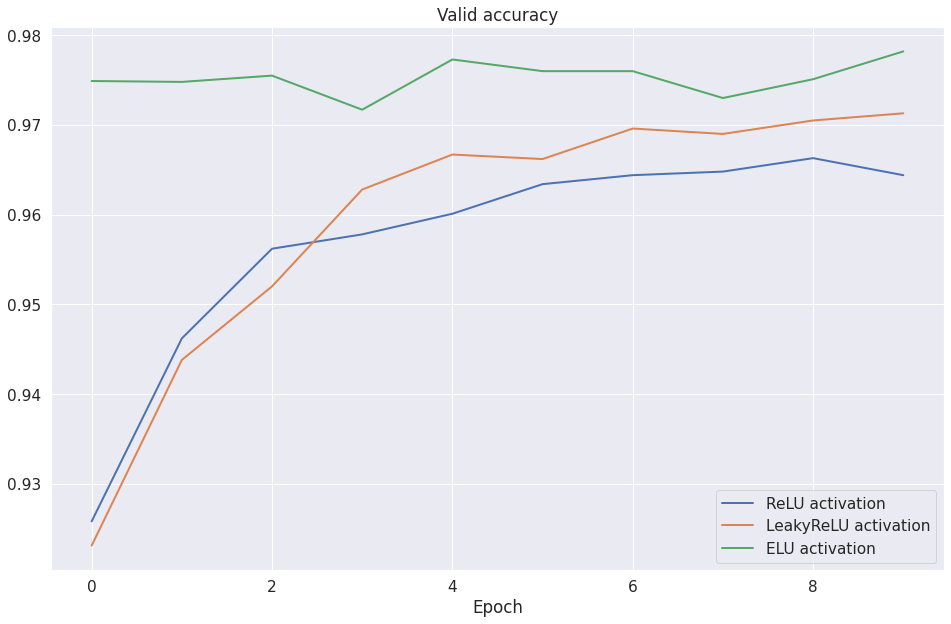

In [152]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [165]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-10-26 19:33:02--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-10-26 19:33:02--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   159KB/s    in 0.3s    

2022-10-26 19:33:03 (159 KB/s) - ‘sample_photo.jpg’ saved [49337/4

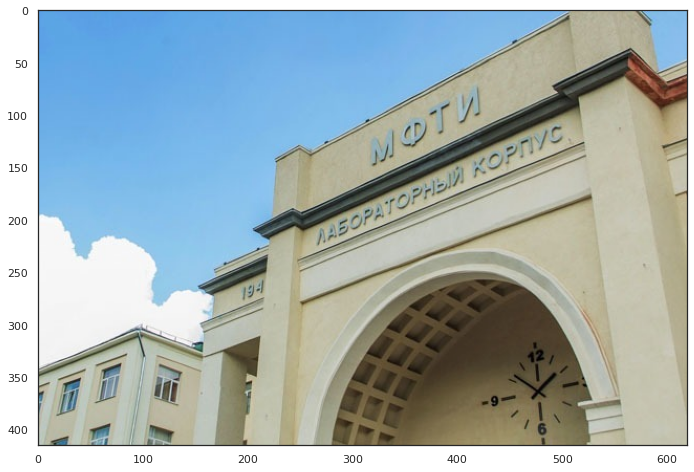

In [199]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [208]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

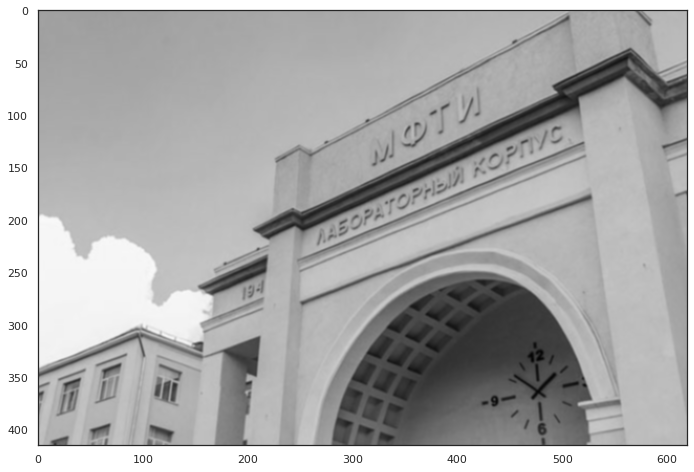

In [209]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**1)Е  2)Д  3)А  4)В  5)Б  6)Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [212]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.activ1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.activ2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(5*5*16,120)
        self.act3  = torch.nn.ReLU()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.ReLU()

        self.fc3   = torch.nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.activ2(x)
        x = self.pool2(x)
        #print(x.shape)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

In [213]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [231]:
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  DataLoader(train_dataset, batch_size=128)
valid_dataloader =  DataLoader(val_dataset, batch_size=128)

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [234]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in train_dataloader:
            if k == "train":
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 model.eval() 
                 with torch.no_grad():
                   outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (y_batch == preds).sum()
            all =  (y_batch == y_batch).sum()
            epoch_correct += correct.item()
            epoch_all += all
            
            if k == "train":
              loss = criterion(outp, y_batch)
              loss.backward()
              optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8855666518211365
Loader: valid. Accuracy: 0.9572166800498962
Epoch: 2
Loader: train. Accuracy: 0.9675666689872742
Loader: valid. Accuracy: 0.9729166626930237
Epoch: 3
Loader: train. Accuracy: 0.9785667061805725
Loader: valid. Accuracy: 0.9814500212669373
Epoch: 4
Loader: train. Accuracy: 0.9833999872207642
Loader: valid. Accuracy: 0.9861000180244446
Epoch: 5
Loader: train. Accuracy: 0.9866333603858948
Loader: valid. Accuracy: 0.9876500368118286
Epoch: 6
Loader: train. Accuracy: 0.9892500042915344
Loader: valid. Accuracy: 0.9887666702270508
Epoch: 7
Loader: train. Accuracy: 0.9909499883651733
Loader: valid. Accuracy: 0.9884333610534668
Epoch: 8
Loader: train. Accuracy: 0.9921333193778992
Loader: valid. Accuracy: 0.9891666769981384
Epoch: 9
Loader: train. Accuracy: 0.9933833479881287
Loader: valid. Accuracy: 0.989983320236206
Epoch: 10
Loader: train. Accuracy: 0.994350016117096
Loader: valid. Accuracy: 0.9927999973297119


In [235]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

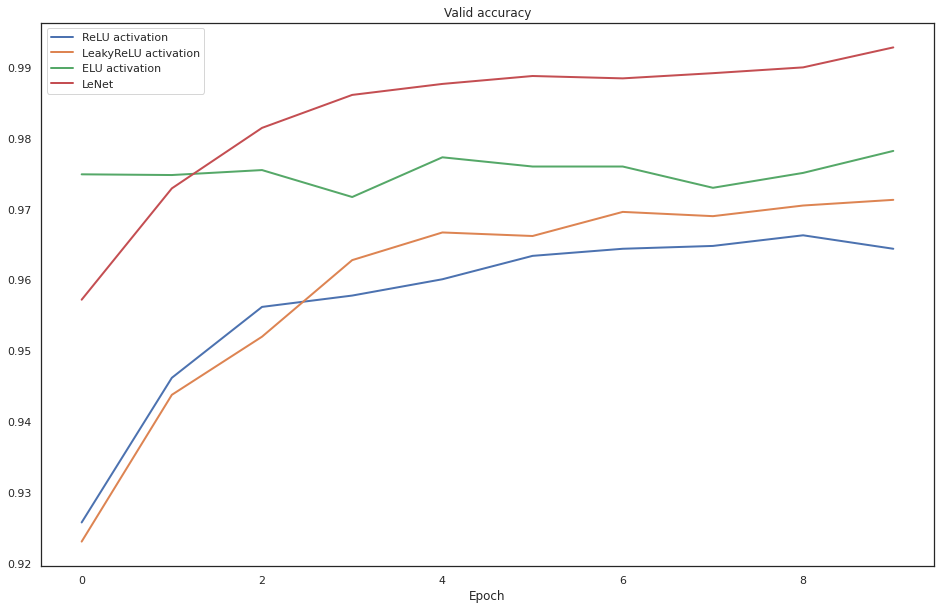

In [236]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.9927